## Importing libraries

In [ ]:
#!conda install -c conda-forge cartopy
#!pip list

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy
import numpy as np
import pandas as pd
import glob
import xarray as xr
import warnings
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.preprocessing import MinMaxScaler
import geopandas as gpd
import rioxarray
from rasterio import features
from affine import Affine

warnings.filterwarnings("ignore")


In [2]:
aod_file = glob.glob('./Data/AOD/*')
aod_file

['./Data/AOD\\3DR_2022_23',
 './Data/AOD\\3D_2014_15',
 './Data/AOD\\3D_2022_23',
 './Data/AOD\\Aeronet',
 './Data/AOD\\INSAT3D',
 './Data/AOD\\INSAT3DR',
 './Data/AOD\\MODIS']

## READ AOD INSAT 3D PATH


In [5]:
aod_insat3D = glob.glob(aod_file[4]+'/*')
aod_insat3D[:5]

['./Data/AOD\\INSAT3D\\3DIMG_01APR2017_0600_L2G_AOD_V01R00.h5',
 './Data/AOD\\INSAT3D\\3DIMG_01APR2017_0630_L2G_AOD_V01R00.h5',
 './Data/AOD\\INSAT3D\\3DIMG_01APR2017_0700_L2G_AOD_V01R00.h5',
 './Data/AOD\\INSAT3D\\3DIMG_01APR2017_0730_L2G_AOD_V01R00.h5',
 './Data/AOD\\INSAT3D\\3DIMG_01APR2017_0800_L2G_AOD_V01R00.h5']

## Loading AOD INSAT 3DR PATH

In [4]:
aod_insat3DR = glob.glob(aod_file[1]+'/*')
aod_insat3DR[:5]

['./Data/AOD\\INSAT3DR\\3RIMG_01APR2017_0545_L2G_AOD_V01R00.h5',
 './Data/AOD\\INSAT3DR\\3RIMG_01APR2017_0615_L2G_AOD_V01R00.h5',
 './Data/AOD\\INSAT3DR\\3RIMG_01APR2017_0645_L2G_AOD_V01R00.h5',
 './Data/AOD\\INSAT3DR\\3RIMG_01APR2017_0715_L2G_AOD_V01R00.h5',
 './Data/AOD\\INSAT3DR\\3RIMG_01APR2017_0745_L2G_AOD_V01R00.h5']

## Loading Files Using Xarray

In [6]:
#ds_3DR = xr.open_mfdataset(aod_insat3DR)
ds_3D = xr.open_mfdataset(aod_insat3D)

In [29]:
ds_temp = ds_3D.sel(time=slice('2017-02-01','2017-02-28')).sortby('time')
ds_temp.time.values[:20]

array(['2017-02-01T05:30:00.000000000', '2017-02-01T06:00:00.000000000',
       '2017-02-01T06:30:00.000000000', '2017-02-01T07:00:00.000000000',
       '2017-02-01T07:30:00.000000000', '2017-02-01T08:00:00.000000000',
       '2017-02-01T08:30:00.000000000', '2017-02-02T06:00:00.000000000',
       '2017-02-02T06:30:00.000000000', '2017-02-02T07:00:00.000000000',
       '2017-02-02T07:30:00.000000000', '2017-02-02T08:00:00.000000000',
       '2017-02-02T08:30:00.000000000', '2017-02-03T05:30:00.000000000',
       '2017-02-03T06:00:00.000000000', '2017-02-03T06:30:00.000000000',
       '2017-02-03T07:00:00.000000000', '2017-02-03T07:30:00.000000000',
       '2017-02-03T08:00:00.000000000', '2017-02-03T08:30:00.000000000'],
      dtype='datetime64[ns]')

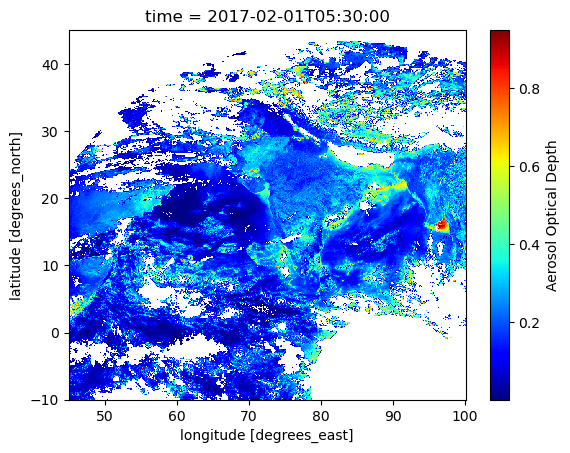

In [24]:
ds_temp.AOD.isel(time=0).plot(cmap='jet')

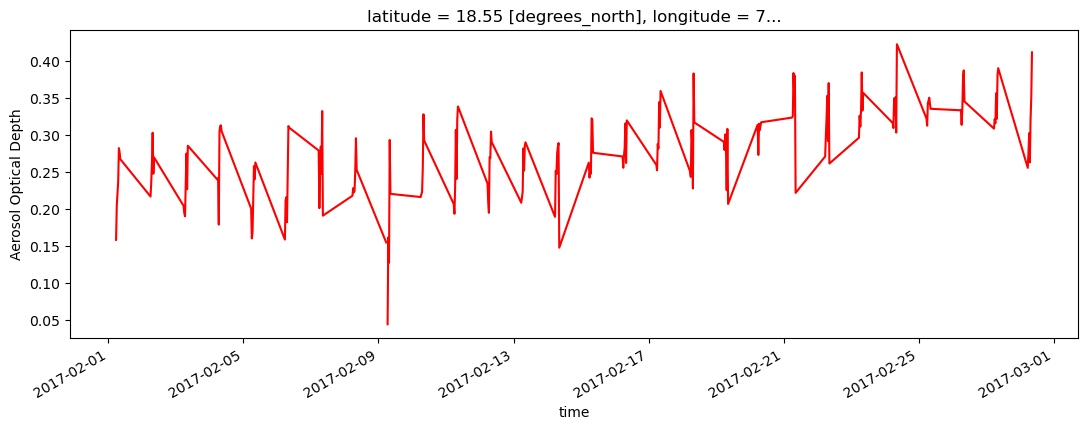

In [27]:
fig,ax  = plt.subplots(figsize=(13,4))
ds_temp.AOD.sel(latitude=18.5204,longitude=73.8567,method='nearest').plot(ax=ax, color='red')
plt.show()

## Getting dataset from 2018 to 2019 and region India (8,38) & (68,98) 

In [6]:
ds1_3DR = ds_3DR.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99))
ds1_3D = ds_3D.sel(time=slice('2018','2019'),latitude=slice(39,8),longitude=slice(67,99))

## MASK Xarray Dataset using shape file

In [7]:
# Transform the latitude and longitude and create porjection for rasterize
def transform_from_latlon(lat, lon):
    lat = np.asarray(lat)
    lon = np.asarray(lon)
    trans = Affine.translation(lon[0], lat[0])
    
    lat_diff = np.diff(lat)
    lon_diff = np.diff(lon)
    
    scale = Affine.scale(lon_diff.min(), lat_diff.min())
    return trans * scale

In [8]:
def rasterize(shapes, coords, latitude="lat", longitude="lon",
              fill=np.nan, **kwargs):
    transform = transform_from_latlon(coords[latitude], coords[longitude])
    out_shape = (len(coords[latitude]), len(coords[longitude]))
    raster = features.rasterize(shapes, out_shape=out_shape,
                                fill=fill, transform=transform,
                                dtype=float, **kwargs)
    spatial_coords = {latitude: coords[latitude], longitude: coords[longitude]}
    return xr.DataArray(raster, coords=spatial_coords, dims=(latitude, longitude))


In [9]:
def add_shape_coord_from_data_array(xr_da, shp_path, coord_name):
    shp_gpd = gpd.read_file(shp_path)
    shapes = [(shape, n) for n, shape in enumerate(shp_gpd.geometry)]
    xr_da[coord_name] = rasterize(shapes, xr_da.coords, 
                               longitude='longitude', latitude='latitude')
    return xr_da

In [ ]:
# Shape file directory
shp_dir=('./Data/India_Boundary/India_Boundary.shp')

ds_mask = add_shape_coord_from_data_array(ds1_3D, shp_dir, "MASK")
ds2_3D = ds_mask.where(ds_mask.MASK==0, other=np.nan)
ds2_3D.drop_vars('MASK')

## Total NaN value in Dataset

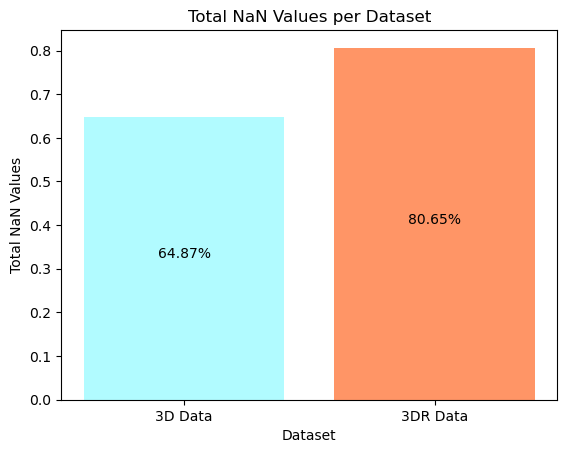

In [7]:
nan_3dr = ds1_3DR.AOD.load().isnull().sum().values
nan_3d = ds1_3D.AOD.load().isnull().sum().values

t,m,n = ds1_3DR.AOD.load().data.shape
tot = t*m*n
nan_3dr = nan_3dr/tot

t,m,n = ds1_3D.AOD.load().data.shape
tot = t*m*n
nan_3d = nan_3d/tot

NaN_data = {'3D Data':nan_3d , '3DR Data': nan_3dr}


# PLot
fig, ax = plt.subplots()
bars = ax.bar(NaN_data.keys(), NaN_data.values(), color=['#7DF9FF', '#FF4F00'],alpha=0.6)

# Annotations
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{round(list(NaN_data.values())[i]*100,2)}%', ha='center')

# Labels and Title
plt.xlabel('Dataset')
plt.ylabel('Total NaN Values')
plt.title('Total NaN Values per Dataset')
plt.show()

## Merging both 3DR and 3D

In [ ]:
ds_merged = xr.concat([ds1_3DR, ds1_3D], dim='time').sortby('time')
ds_merged

In [ ]:
#ds_merged = ds_merged.sel(time = slice('2018-06-01','2018-10-01'))

## Total Negative Value 

In [ ]:
#No of negative values in dataset
pos = np.sum(ds_merged.AOD.load().data > 0)
neg = np.sum(ds_merged.AOD.load().data <= 0)
NaN = ds_merged.AOD.load().isnull().sum().data

t,m,n = ds_merged.AOD.load().data.shape
tot = t*m*n

# Data dict
Data = {'NaN':np.round(NaN/tot,2)*100 , 'Positive': np.round((pos/tot)*100,2),'Negative':np.round((neg/tot)*100,2)}

# PLot
fig, ax = plt.subplots()
bars = ax.bar(Data.keys(), Data.values(), color=['#7DF9FF', '#FF4F00','#FF00FF'],alpha=0.6)

# Annotations
for i, bar in enumerate(bars):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, f'{list(Data.values())[i]}%', ha='center')

# Labels and Title
plt.xlabel('Dataset')
plt.ylabel('Total Data')
plt.title('NAN vs Positve vs Negative')
legend_labels = ['NaN', 'Postive','Negative']
plt.legend(bars, legend_labels)
plt.show()

In [ ]:
# ds_time = ds1.dropna("time", how="all")
# ds_time

In [ ]:
#Converting negative value by NaN values
ds_merged1 = ds_merged.where(ds_merged.AOD > 0)
ds_merged1

### No of negative values in dataset after replacing negative value

In [ ]:
pos = np.sum(ds_merged1.AOD.load().data > 0)
neg = np.sum(ds_merged1.AOD.load().data <= 0)
NaN = ds_merged1.AOD.load().isnull().sum().data
t,m,n = ds_merged1.AOD.load().data.shape
tot = t*m*n
print(f'Total values :{tot} \nNaN:{np.round(NaN/tot,2)*100}% \nPositive AOD value:{np.round((pos/tot)*100,2)}% \nNegative AOD value:{np.round((neg/tot)*100,2)}% \nMin AOD value:{ds_merged1.AOD.min().load().values}')

## Analyzing no of data points in a single Day

In [ ]:
#For merged Data
time_da = ds_merged1.time.dt.floor("1D")
df = pd.DataFrame(time_da,columns=['Day'])

x = df.Day.unique()
freq = df.Day.value_counts().sort_index()
data = {'Day':x,'Freq':freq}
df2 = pd.DataFrame(data)


In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(11,5))


#AXIS 1 Histogram
sns.histplot(data=df2, x='Freq',color="orange",ax=ax[0])
ax[0].set_xlabel('Frequency')
ax[0].set_ylabel('Days')
ax[0].set_xticks(np.arange(1,21,1))
ax[0].set_yticks(np.arange(0,360,25))


#AXIS 2 Line Plot
sns.lineplot(x="Day", y="Freq", data=df2,ax=ax[1],linewidth=1.2)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Frequency')
plt.xticks(rotation=25)

plt.subplots_adjust(wspace=0.4)
fig.suptitle('Frequency Analysis', fontsize=14, fontweight='bold')
plt.show()

## Discard Date which has less than 4 records

In [ ]:
# def filter_func(group):
#     if len(group.time) >= 4:
#         return group
#     else:
#         return xr.Dataset()

In [ ]:
# ds_daily = ds2.resample(time='1D').count(dim='time')

# Group by day and filter out groups with fewer than 4 data points
# ds_daily_filtered = ds_daily.groupby('time.dayofyear').apply(filter_func)

# df_daily = ds_daily.to_dataframe()

In [ ]:
# df_daily.sample(10)

## Count number of records that have NaN value in particular day

In [ ]:
test_ds = ds_merged1
test_ds1 = test_ds.resample(time='1D').apply(lambda x: x.isnull().sum())

In [ ]:
data = {'Day':test_ds1.time.data,'NaN':test_ds1.AOD.data}
df_merged = pd.DataFrame(data)

## Scaling using MinMaxScaler

In [ ]:
scaler = MinMaxScaler()
df_merged.NaN = scaler.fit_transform(df_merged.NaN.values.reshape(-1,1))
df_merged.head(5)

In [ ]:
#Plotting Histogram
df_merged.NaN.describe()

In [ ]:
sns.displot(df_merged.NaN, kde=True, color='blue', alpha=0.5)
plt.title('Distribution of NaN value')
plt.xlabel('NaN value')
plt.ylabel('Count')
plt.show()

## Getting Montly Data

In [ ]:
start_date = '2018-01' # starting year from which records are taken.
ds2 = ds1.resample(time = "1M").mean()
ds2['time'] = pd.date_range(start_date,periods=len(ds2.time),freq='MS')
ds2

## Reindexing latitude

In [ ]:
ds3 = ds2.reindex(latitude=ds2.latitude[::-1])
ds3

In [ ]:
#Plotting graph for montly data
fig = plt.figure(figsize=(7,5))
cmap = plt.cm.get_cmap('RdBu')
ds3.AOD.isel(time=0).plot(cmap = cmap)

## Regridding 0.1 X 0.1(AOD) to 0.25 X 0.25(BHL)

In [ ]:
#output resolution
out_res = float(0.25)

#half of orginal resolution
interval_window = out_res/2 
new_lat = np.arange(8-interval_window, 38 + out_res, out_res) # Latitude label i.e 8,..,38
new_lon = np.arange(68-interval_window, 98 + out_res, out_res) # longitude Label i.e 68,..,98


ds4 = ds3.groupby_bins("longitude", bins=new_lon).mean(dim="longitude").groupby_bins("latitude", bins=new_lat).mean(dim="latitude")

#Renaming longitude and latitude coordinate
ds4 = ds4.rename({"longitude_bins":"longitude","latitude_bins":"latitude"})

ds4['latitude'] = new_lat[:-1] + interval_window
ds4['longitude'] = new_lon[:-1] + interval_window

ds4

## plotting graph

In [ ]:
aod_da = ds4.AOD.load()

In [ ]:
fig = plt.figure(figsize=(7,5))
cmap = plt.cm.get_cmap('jet')
projection=ccrs.PlateCarree(central_longitude=0)
ax=plt.axes(projection=projection)
#cmap = plt.cm.get_cmap('RdBu') ##Red/Blue 
#lat and long limits

ds4.AOD.isel(time=0).plot(vmin = aod_da.min(),vmax = aod_da.max(),cmap = cmap.reversed(),ax=ax)
ax.set_extent([68,98,8,38], crs=projection)
ax.coastlines() #adding coastline
#ax.gridlines() #adding gridlines
ax.set_xticks(ds4.longitude[::10])
ax.set_yticks(ds4.latitude[::10])
ax.add_feature(cartopy.feature.BORDERS, linestyle='-', edgecolor='black') ##Adding borders
ax.add_feature(cartopy.feature.STATES, linestyle='-', edgecolor='black') ##adding state borders
plt.show()

In [ ]:
plt.rcParams["figure.figsize"] = [12.00, 5.00]
plt.rcParams["figure.autolayout"] = True
fig1 = ds4.AOD.sel(latitude=23.0225,longitude=72.5714,method='nearest').plot(x='time',marker = 'o',color = 'cyan',label='Ahmedabad' )
fig2 = ds4.AOD.sel(latitude=26.84,longitude=80.9462,method='nearest').plot(x='time',marker = 'o',color = 'red',label='lucknow')
plt.xticks(ds4.AOD.time)
plt.legend()
plt.show()